### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
import time

# MRS Load in the data
data = np.load('../../../homeworks/hw_data/hw5_data_1.npy')
t = data[:,0]
flux = data[:,1]
uncert = data[:,2]



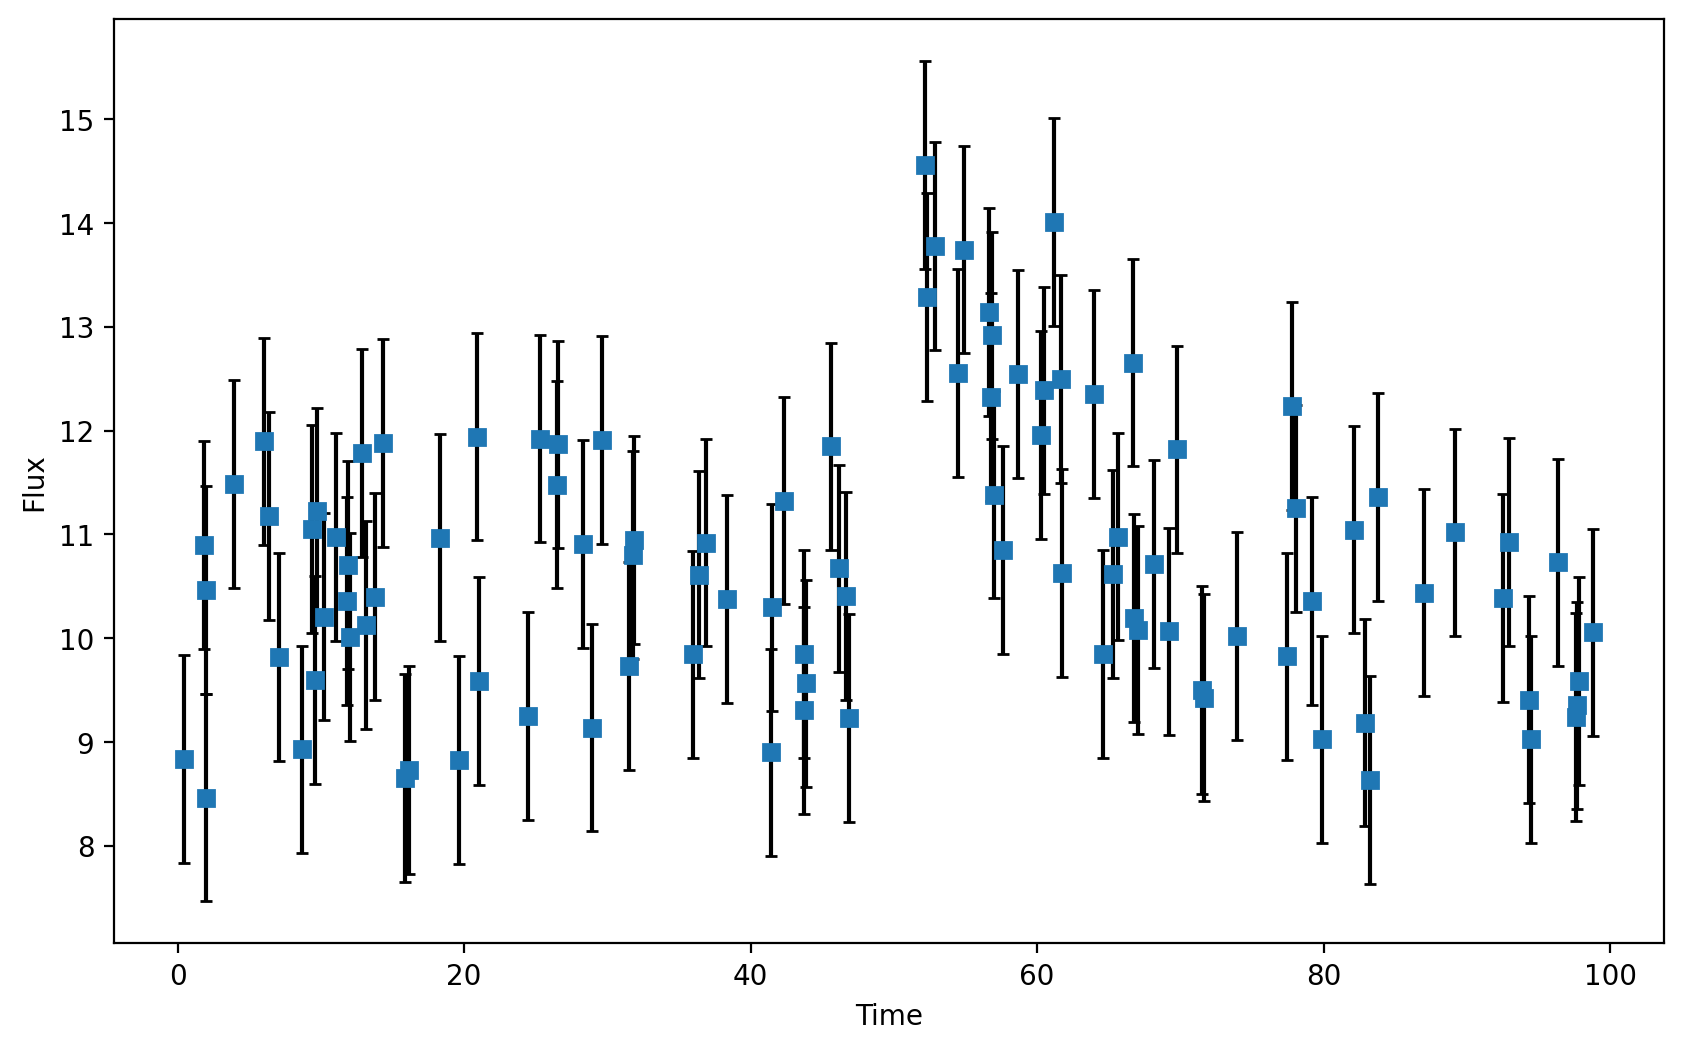

In [2]:
fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(t, flux, yerr=uncert,ls='', capsize=2, color='black')
ax.plot(t, flux, 's')
ax.set_ylabel('Flux')
ax.set_xlabel('Time')
plt.show()

In [ ]:


#Functions to do a polynomial fit, and compute the likelihood
def burst_fit(params, t):
    # params is an array with the 4 fitting parameters [b, Amplitude, lnalpha, t_0]
    y = np.zeros(len(t))  
    y[np.where(t < params[3])] = params[0]
    y[np.where(t >= params[3])] = params[0] + params[1] * np.exp(-np.exp(params[2]) * (t[np.where(t >= params[3])] - params[3]))
    return y


# compute the data log-likelihood given a model
def logL(params, data, model=burst_fit):
    t, flux, flux_uncert = data
    y_fit = model(params, t)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(flux, y_fit, flux_uncert))

# MRS Defining a function for a uniform distribution over the range (loc, loc+scale)
def unif_prior(x, loc, scale):
    return uniform(loc, scale).pdf(x)


def myLogPosterior(params, data):
    log_prior =  np.log(unif_prior(params[0], 0, 50)) +  np.log(unif_prior(params[1], 0, 50)) + np.log((unif_prior(params[2], -5, 10))) + np.log(unif_prior(params[3], 0, 100))
    log_likelihood = logL(params, data)
    
    return log_prior + log_likelihood




In [22]:
import emcee

ndim = 4  # number of parameters in the model
nwalkers = 15  # number of MCMC walkers
burn = 0  # "burn-in" period to let chains stabilize
nsteps = 20000  # number of MCMC steps to take **for each walker**
data = [t, flux, uncert]
# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[data])
sampler.run_mcmc(starting_guesses, nsteps, progress = True)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

  0%|          | 0/20000 [00:00<?, ?it/s]/var/folders/ls/sw9901md6hg56d8jmwp77nyr0000gp/T/ipykernel_11991/1870403717.py:26: RuntimeWarning: divide by zero encountered in log
  log_prior =  np.log(unif_prior(params[0], 0, 50)) +  np.log(unif_prior(params[1], 0, 50)) + np.log((unif_prior(params[2], -5, 10))) + np.log(unif_prior(params[3], 0, 100))
100%|██████████| 20000/20000 [21:50<00:00, 15.26it/s]

done


In [37]:
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
burn = 2000
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

done


In [38]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain


(15, 20000, 4)
(270000, 4)


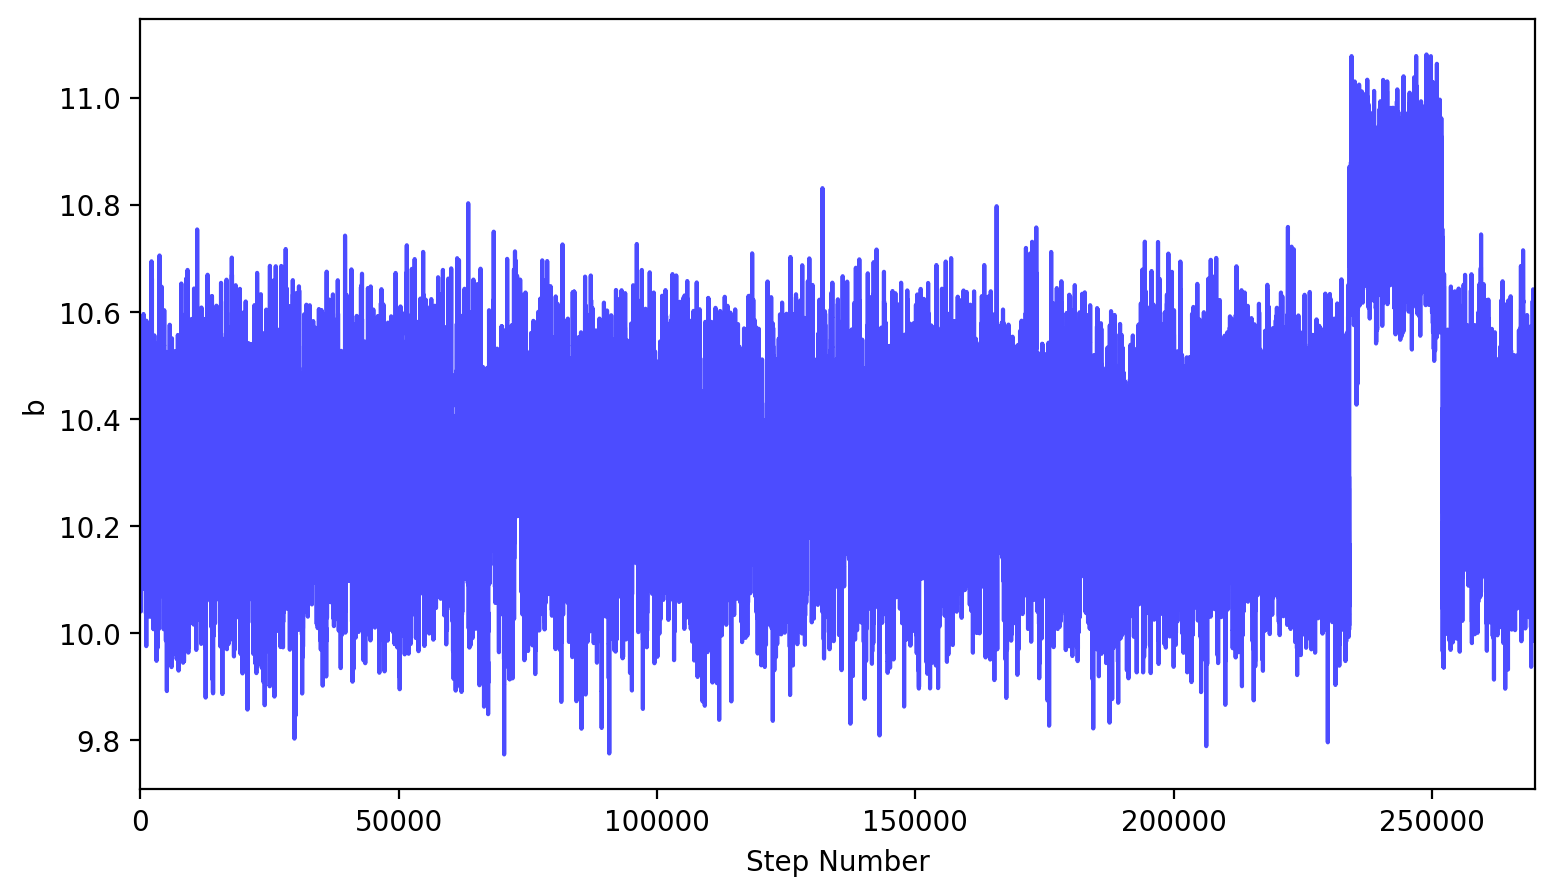

In [39]:

fig, ax1 = plt.subplots(figsize=(9, 5))  # Create figure and axis

chainE = emcee_trace[:, 0] 
M = np.size(chainE)

xgrid = np.linspace(1, M, M) 

ax1.plot(xgrid, chainE, color='b', alpha=0.7)  
ax1.set_xlim(0, M)
#ax1.set_ylim(np.min(chainE), 1.1 * np.max(chainE))
ax1.set_xlabel('Step Number')
ax1.set_ylabel('b')

plt.show()  


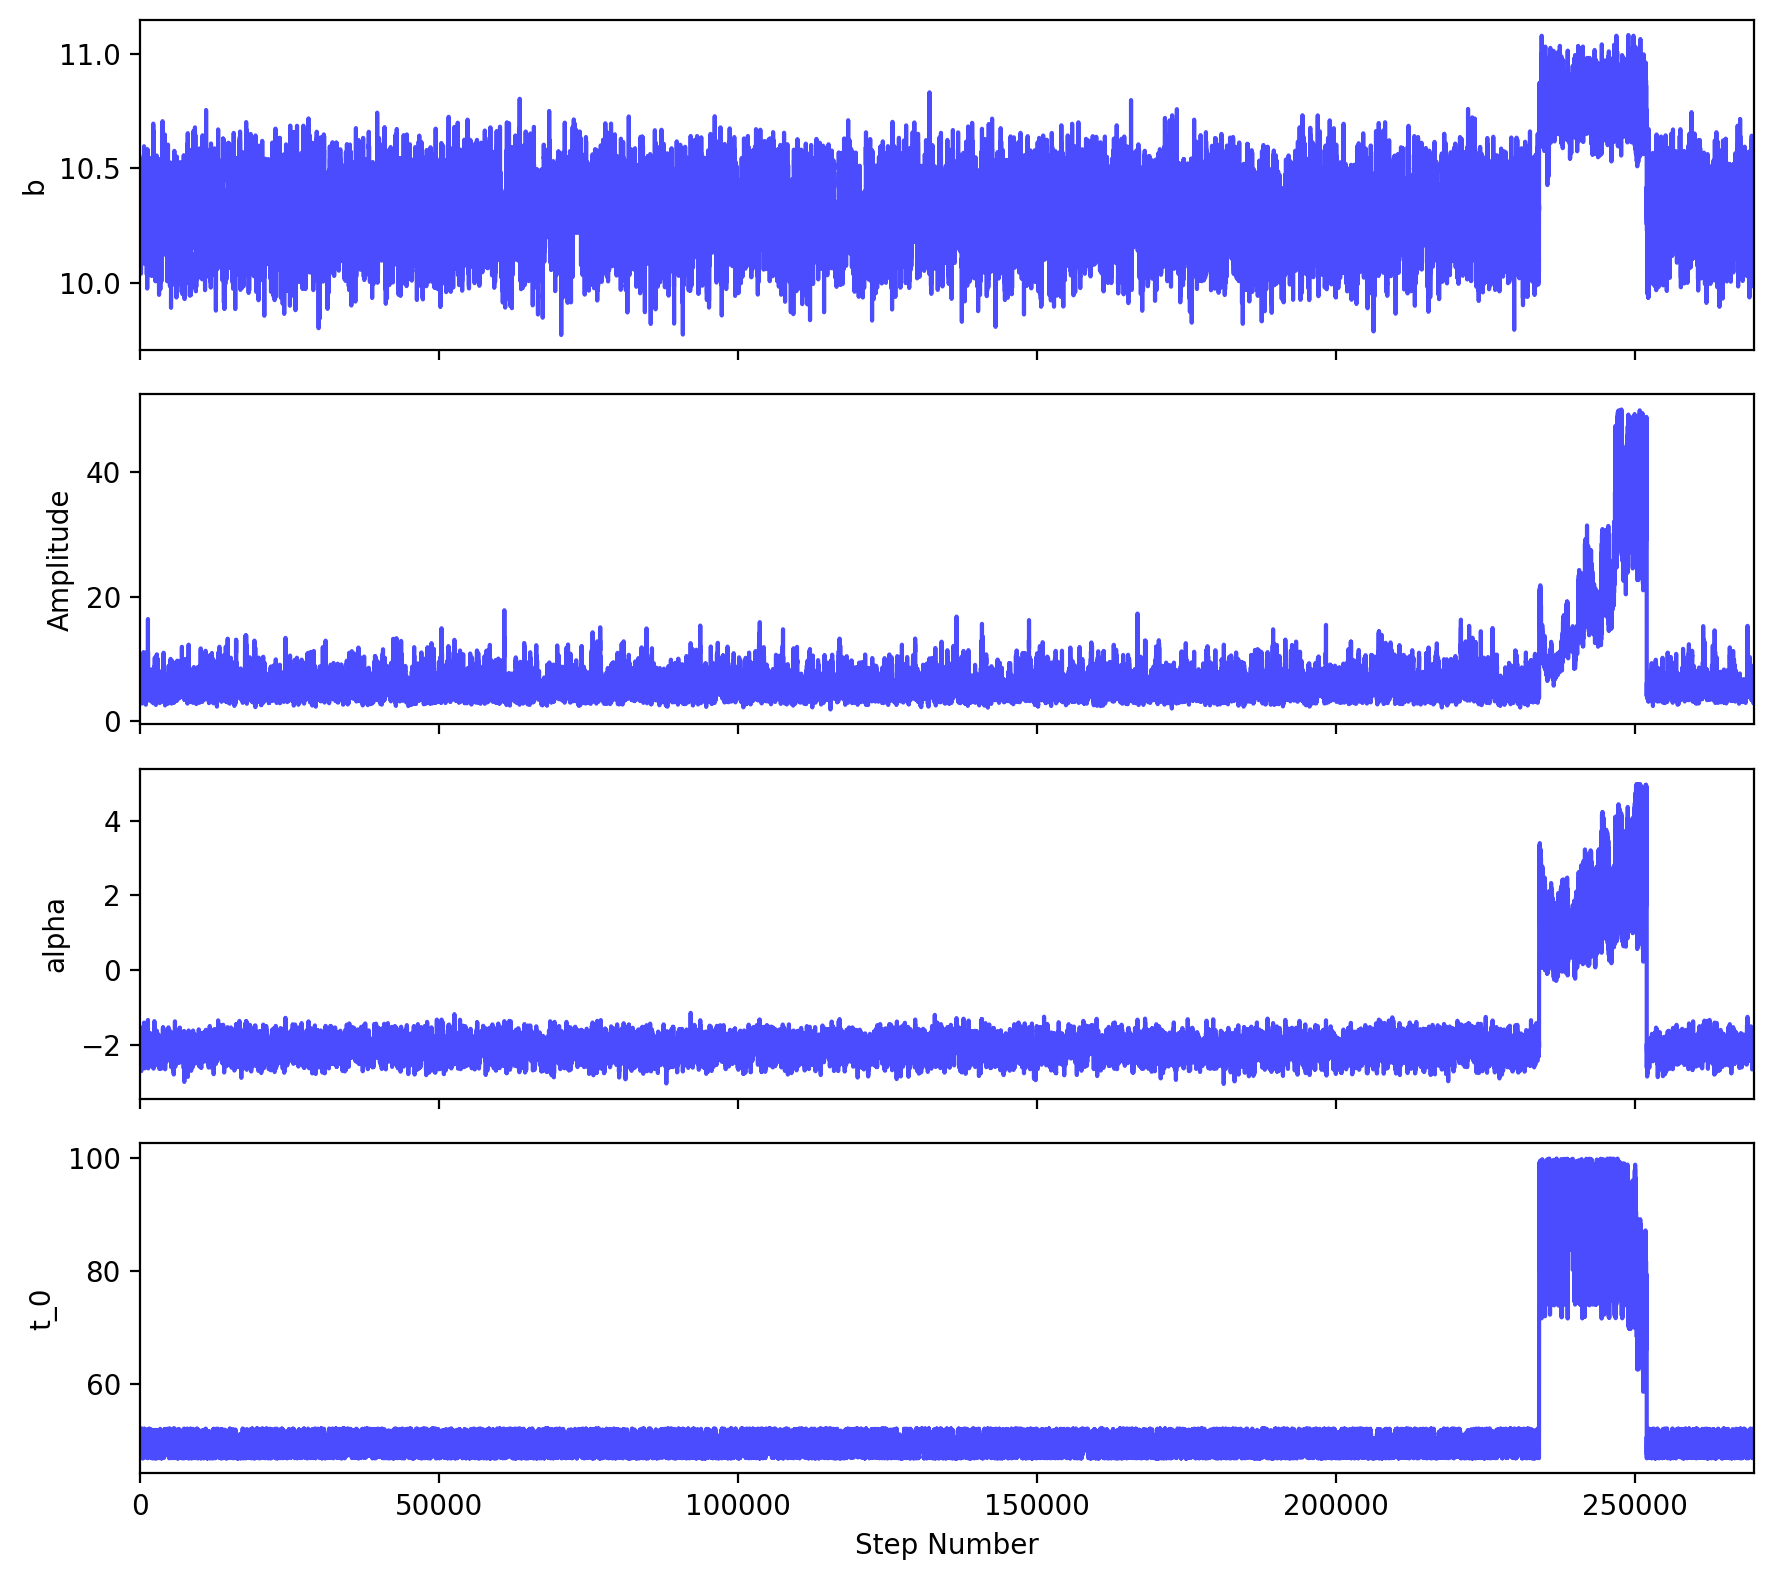

In [40]:
fig, axes = plt.subplots(ndim, figsize=(9, 2 * ndim), sharex=True)

y_labels = ['b', 'Amplitude', 'alpha', 't_0' ]
for i in range(ndim):
    axes[i].plot(emcee_trace[:, i], color='b', alpha=0.7)
    axes[i].set_ylabel(f'{y_labels[i]}')
    axes[i].set_xlim(0, len(emcee_trace))
    
axes[-1].set_xlabel('Step Number')
plt.tight_layout()
plt.show()

# plot running mean: 
# meanC = [np.mean(chainE[:int(N)]) for N in xgrid]
# plt.plot(xgrid, meanC, c='red', label='chain mean') 
# plt.legend()


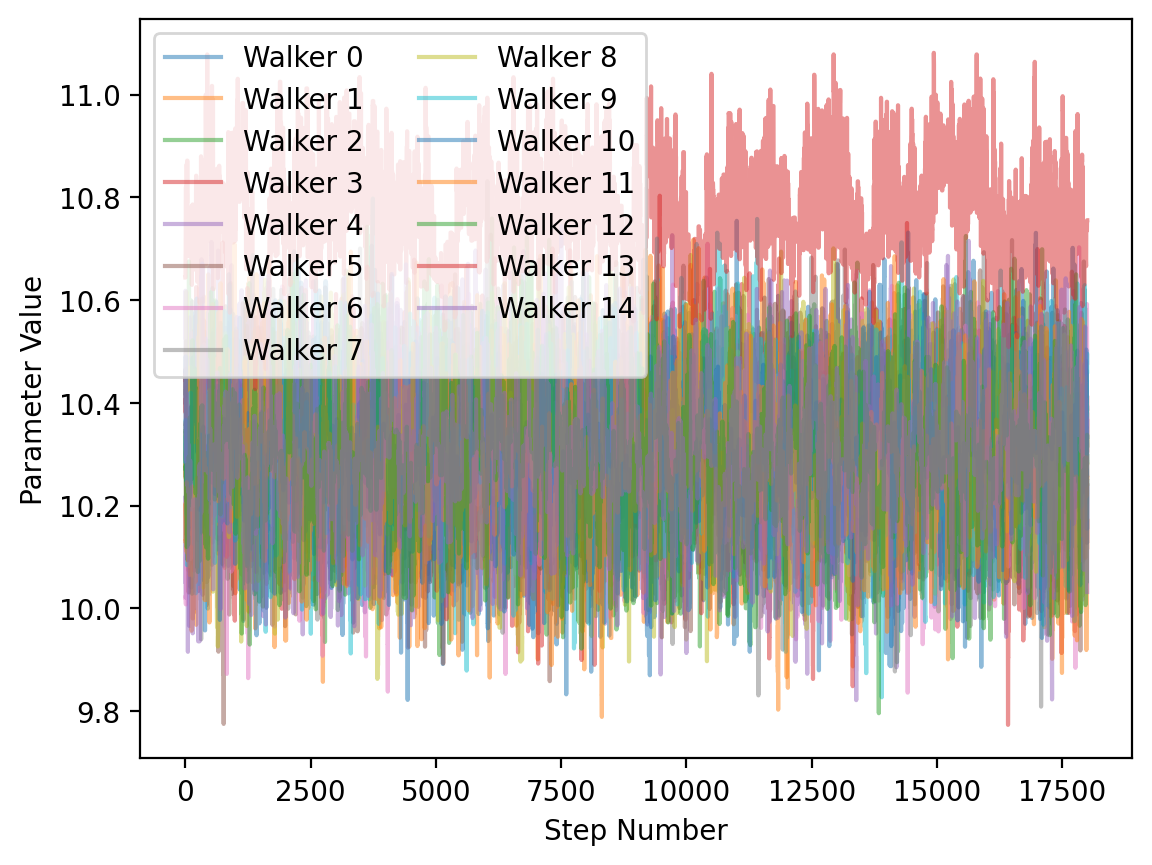

In [66]:
reshaped_chain = emcee_trace.reshape(15, 18000, 4)

for i in range(15):  
    plt.plot(reshaped_chain[i, :, 0], alpha=0.5, label=f'Walker {i}')  

plt.xlabel("Step Number")  
plt.ylabel("Parameter Value")  
plt.legend(loc='best', ncol=2)  
plt.show()

In [42]:
good_walkers = [i for i in range(15) if i != 13]
cleaned_chain = reshaped_chain[good_walkers, :, :].reshape(-1, 4)

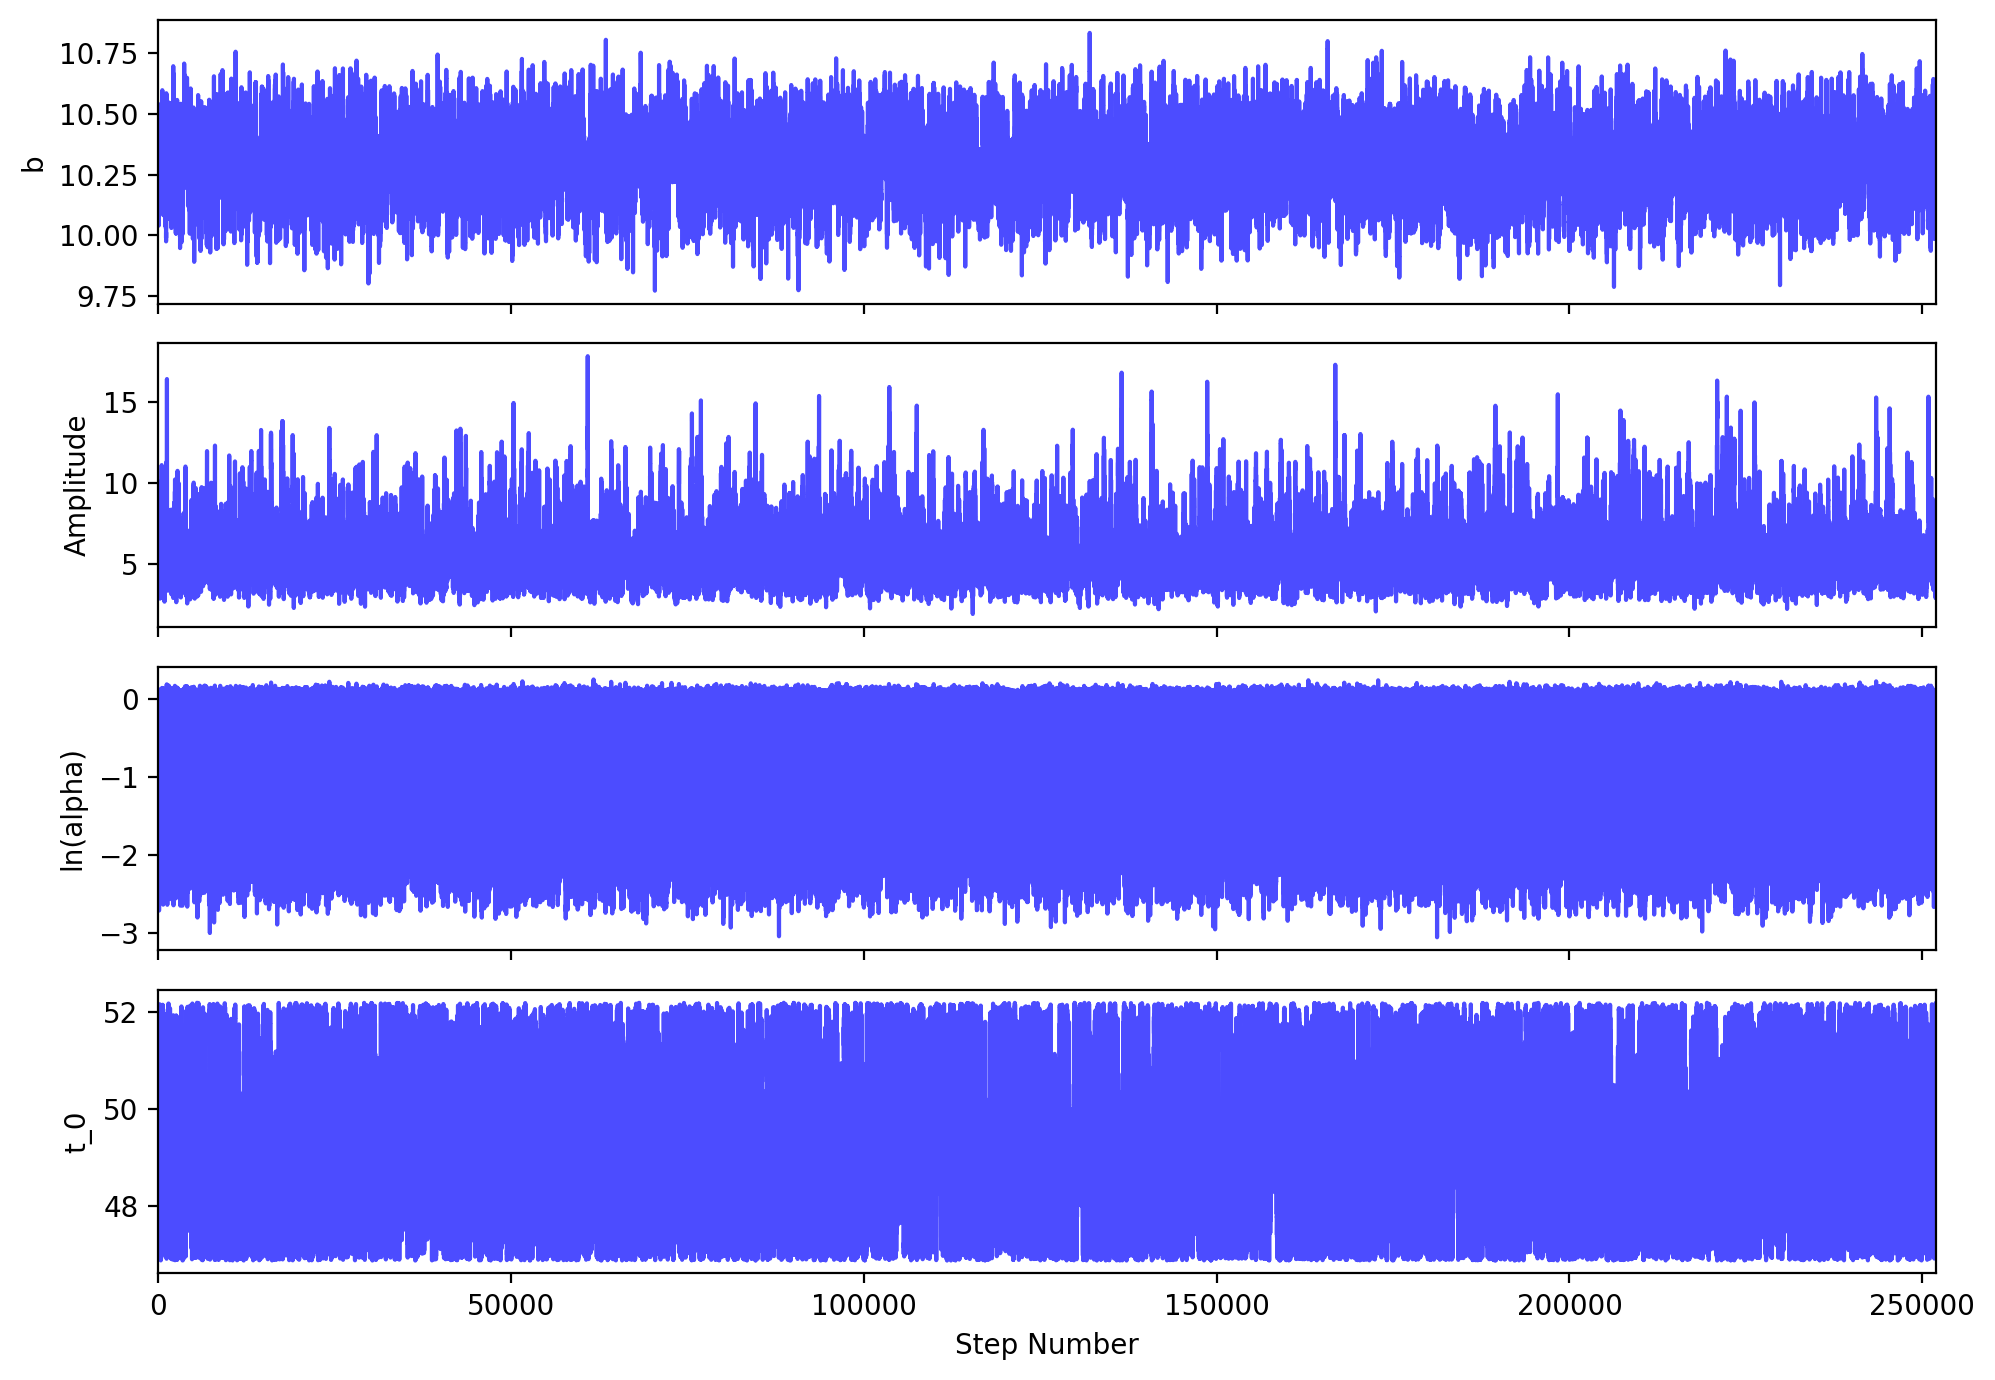

In [67]:

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

y_labels = ['b', 'Amplitude', 'ln(alpha)', 't_0' ]
for i in range(ndim):
    axes[i].plot(cleaned_chain[:, i], color='b', alpha=0.7)
    axes[i].set_ylabel(f'{y_labels[i]}')
    axes[i].set_xlim(0, len(cleaned_chain))
    
axes[-1].set_xlabel('Step Number')
plt.tight_layout()
plt.show()

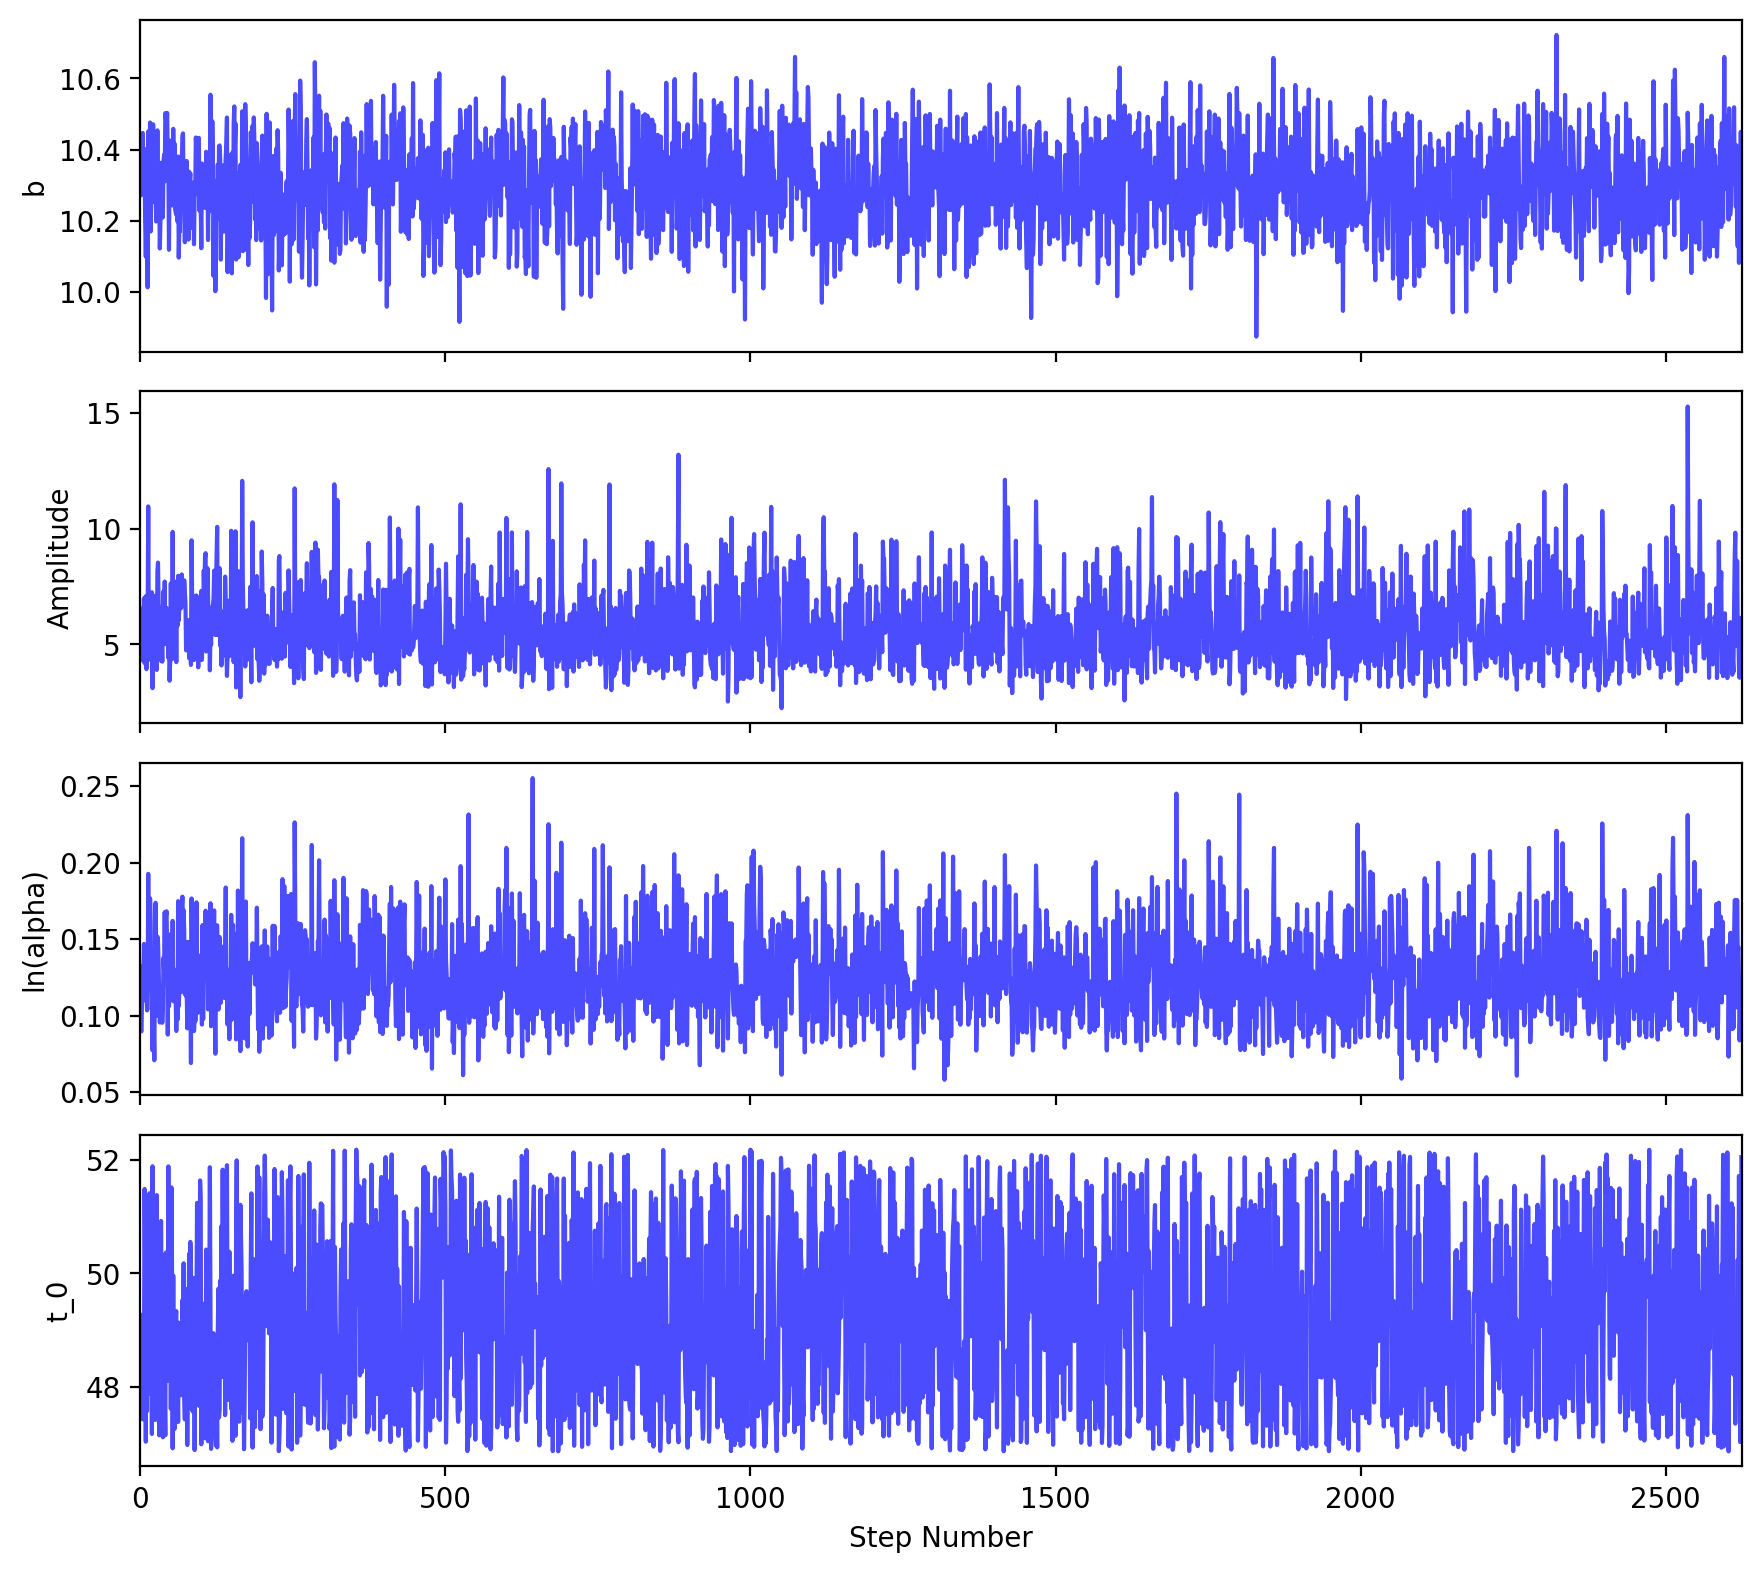

In [68]:
import acor 

acors = []
for i in range(ndim):
    acors.append(round(acor.acor(cleaned_chain[:,i])[0]))



thinned_chains = cleaned_chain[::np.max(acors), :]
fig, axes = plt.subplots(ndim, figsize=(9, 2 * ndim), sharex=True)

y_labels = ['b', 'Amplitude', 'ln(alpha)', 't_0' ]
for i in range(ndim):
    axes[i].plot(thinned_chains[:, i], color='b', alpha=0.7)
    axes[i].set_ylabel(f'{y_labels[i]}')
    axes[i].set_xlim(0, len(thinned_chains))
    
axes[-1].set_xlabel('Step Number')
plt.tight_layout()
plt.show()

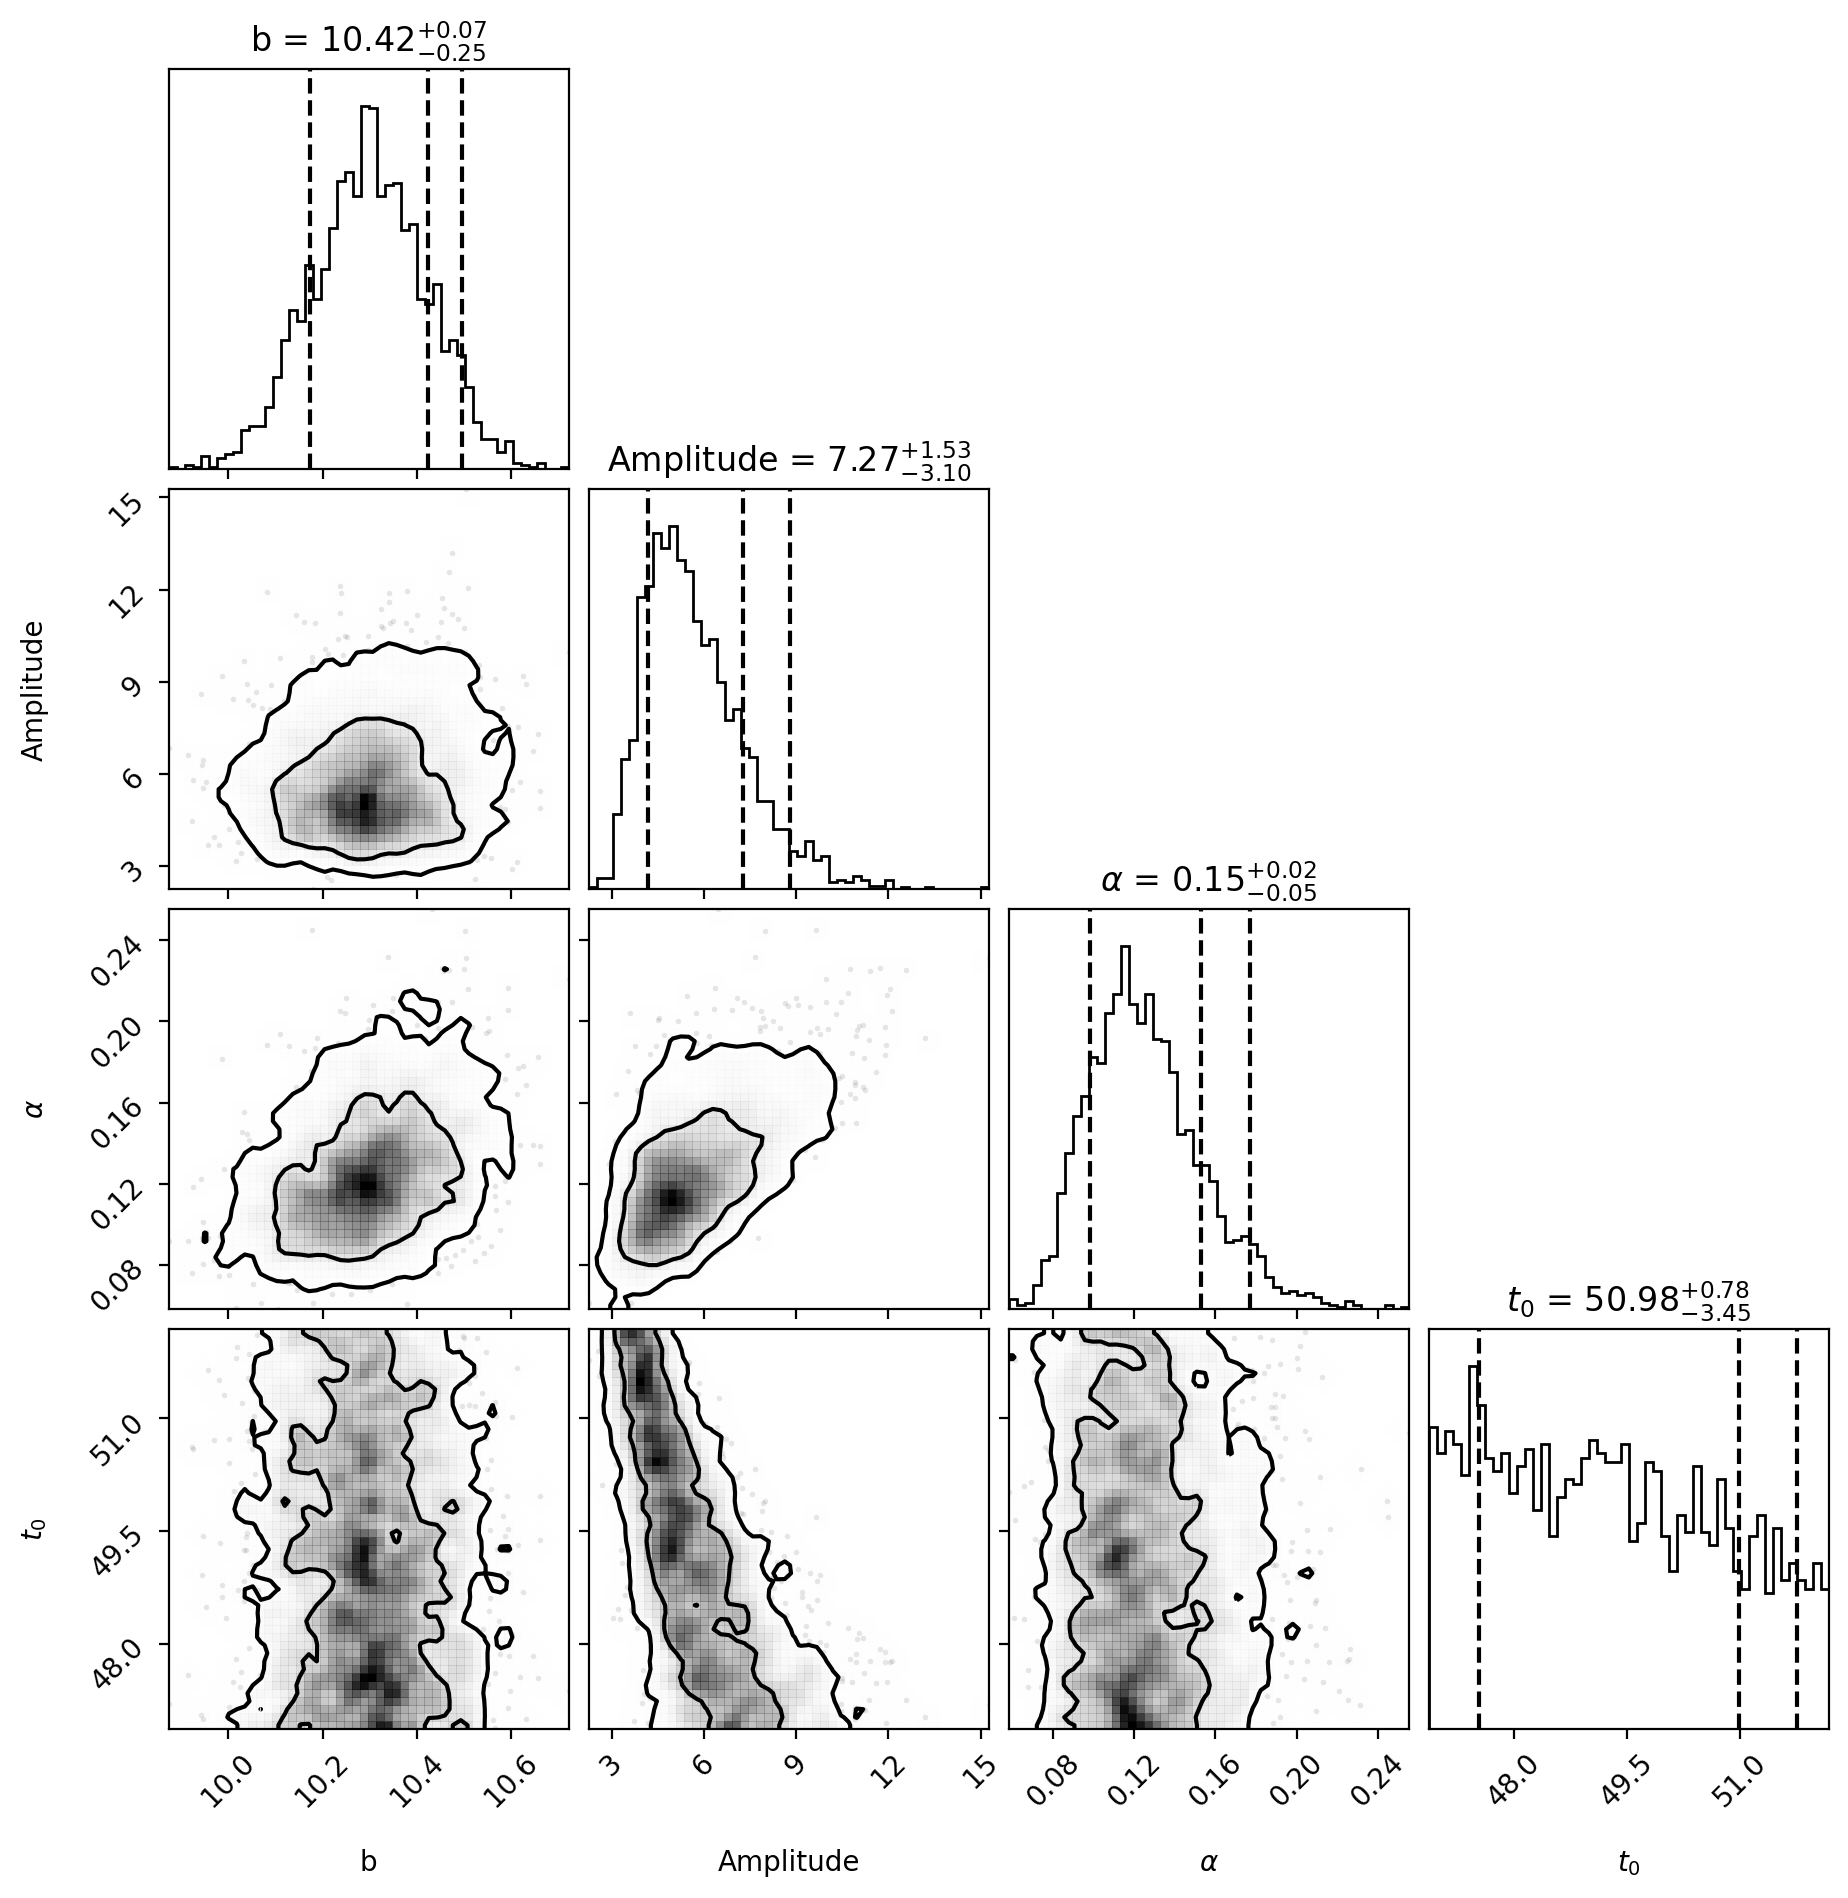

In [ ]:
import corner

# MRS combine both paramaters for the 2D plot in corner plot


labels = [r"b", r"Amplitude", r'$\alpha$', r'$t_0$']

# MRS converting the third parameter ln(alpha) in just alpha
conv_alpha = thinned_chains
conv_alpha[:, 2] = np.exp(conv_alpha[:,2])


# MRS plot the data with 68% and 95% confidence levels
fig = corner.corner(
    conv_alpha, labels=labels, show_title=True, titles = [r"b", r"Amplitude", r'$\alpha$', r'$t_0$'], show_titles=True,  bins=50,  smooth=1.0, plot_density=True, plot_contours=True, 
    levels=[0.68, 0.95], quantiles=[0.16, 0.84, 0.95])

plt.show()

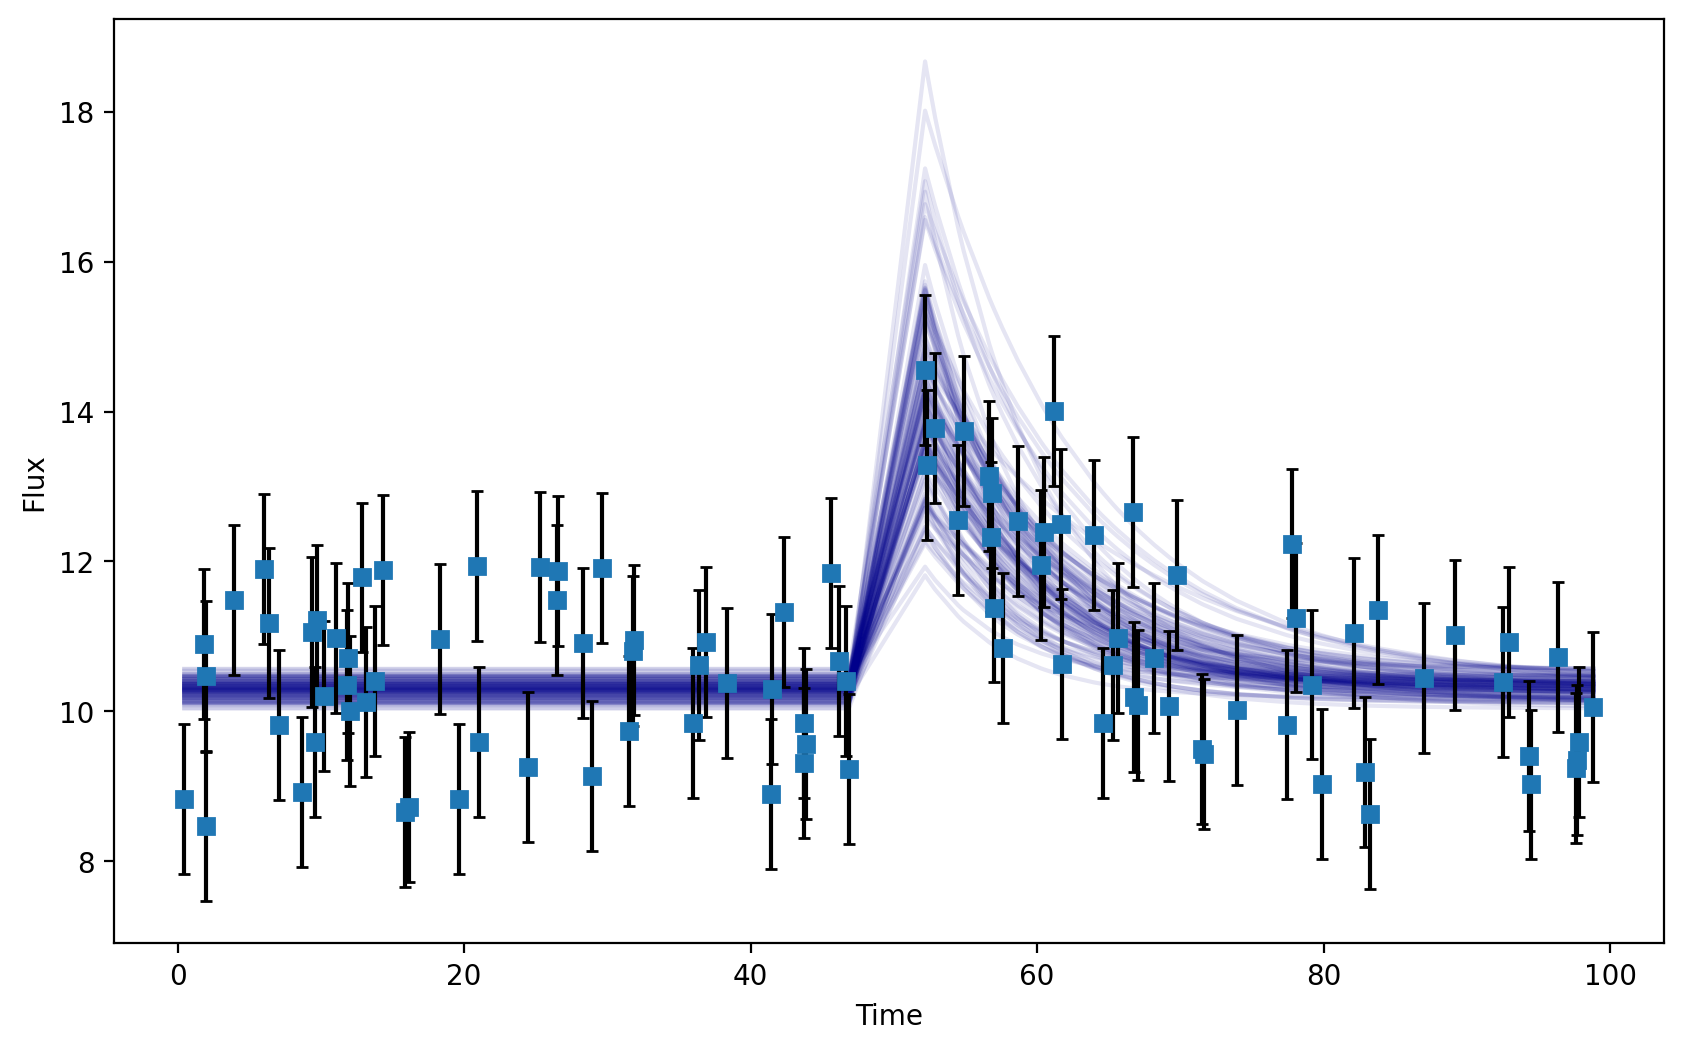

In [52]:
pulled_params = np.zeros((100, ndim))
for i in range(ndim):  
    pulled_params[:, i] = np.random.choice(thinned_chains[:, i], size=100, replace=False)  

fig, ax = plt.subplots(figsize=(10,6))

for params in pulled_params:
    y_fit = burst_fit(params, t)  
    ax.plot(t, y_fit, color='darkblue', alpha=0.1)  


ax.errorbar(t, flux, yerr=uncert,ls='', capsize=2, color='black')
ax.plot(t, flux, 's')
ax.set_ylabel('Flux')
ax.set_xlabel('Time')
plt.show()

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

In [ ]:
def my_likelihood(params):
    b, amplitude, sig, t_0 = params

    # compute intensity at every x position according to the model
    y_model = b + amplitude * np.exp((-(t-t_0)**2) / (2*sig**2))
    # compare model and data with gaussian likelihood:
    like = -0.5 * (((y_model - flux)/uncert)**2).sum()
    return like


def my_prior_transform(cube):
    params = cube.copy()

    # transform b parameter: uniform prior
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo

    # transform amplitude parameter: uniform prior
    lo = 0
    hi = 50
    params[1] = cube[1] * (hi - lo) + lo

    # transform amplitude parameter: log-uniform prior
    lo = np.exp(-2)
    hi = np.exp(2)
    params[2] = np.exp(cube[2] * (np.log(hi) - np.log(lo)) + np.log(lo))


     # transform t_0 parameter: uniform prior
    lo = 0
    hi = 100
    params[3] = cube[3] * (hi - lo) + lo
    return params


In [86]:
import ultranest
param_names = ["b", "Amplitude", 'ln(simga)', 't_0']
ult_sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, 
                                          my_prior_transform)

In [ ]:
result_ult = ult_sampler.run()
ult_sampler.print_results()
gauss_params = ult_sampler.results['posterior']['mean']

[ultranest] Widening roots to 400 live points (have 400 already) ...
[ultranest] Explored until L=-5e+01  
[ultranest] Likelihood function evaluations: 62873
[ultranest]   logZ = -67.6 +- 0.1285
[ultranest] Effective samples strategy satisfied (ESS = 2186.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.

logZ = -67.592 +- 0.262
  single instance: logZ = -67.592 +- 0.181
  bootstrapped   : logZ = -67.598 +- 0.262
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.78  │ ▁▁▁▁ ▁▁▁▁▁▁▃▃▄▄▅▆▆▇▆▇▅▅▄▄▂▃▁▁▁▁▁▁▁▁ ▁ │10.83     10.32 +- 0.12
    Amplitude           : 1.13  │ ▁▁   ▁▁▁▁▁▂▃▄▅▆▆▇▆▆▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁ ▁ │4.62      2.76 +- 0.38
    ln(simga)           : 1.62  │ 

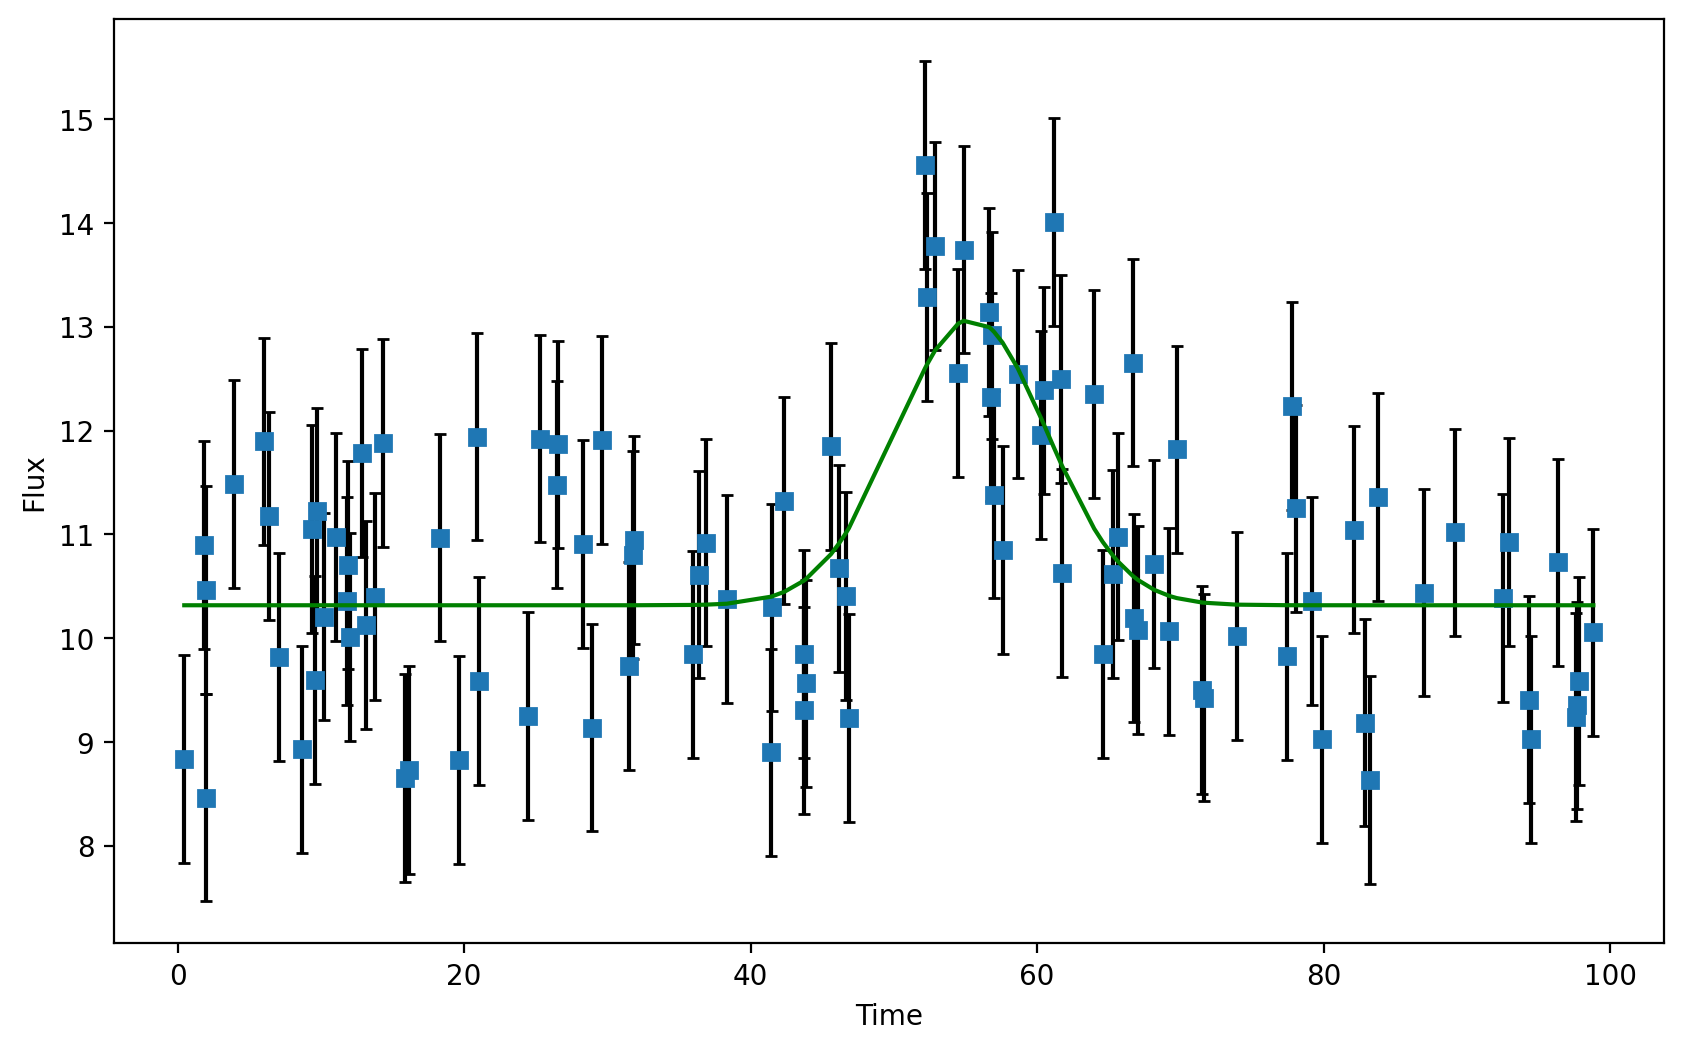

In [128]:

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(t, flux, yerr=uncert,ls='', capsize=2, color='black')
ax.plot(t, flux, 's')
ax.plot(t, gauss_params[0] + gauss_params[1] * np.exp((-(t-gauss_params[3])**2) / (2*gauss_params[2]**2)), color='green')

ax.set_ylabel('Flux')
ax.set_xlabel('Time')
plt.show()

In [90]:
def my_likelihood(params):
    b, amplitude, alpha, t_0 = params
    y_model = np.zeros(len(t))
    y_model[np.where(t < t_0)] = b
    y_model[np.where(t >= t_0)] = b + amplitude * np.exp(-alpha * (t[np.where(t >= t_0)] - t_0))
    # compute intensity at every x position according to the model
  
    # compare model and data with gaussian likelihood:
    like = -0.5 * (((y_model - flux)/uncert)**2).sum()
    return like


def my_prior_transform(cube):
    params = cube.copy()

    # transform b parameter: uniform prior
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo

    # transform amplitude parameter: uniform prior
    lo = 0
    hi = 50
    params[1] = cube[1] * (hi - lo) + lo

    # transform amplitude parameter: log-uniform prior
    lo = np.exp(-5)
    hi = np.exp(5)
    params[2] = np.exp(cube[2] * (np.log(hi) - np.log(lo)) + np.log(lo))


     # transform t_0 parameter: uniform prior
    lo = 0
    hi = 100
    params[3] = cube[3] * (hi - lo) + lo
    return params


In [92]:
param_names = ["b", "Amplitude", 'alpha', 't_0']
ult_burst_sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, 
                                          my_prior_transform)

In [130]:
result_burst = ult_burst_sampler.run()
ult_burst_sampler.print_results()
burst_params = ult_burst_sampler.results['posterior']['mean']

[ultranest] Widening roots to 400 live points (have 400 already) ...
[ultranest] Explored until L=-5e+01  
[ultranest] Likelihood function evaluations: 66898
[ultranest]   logZ = -63.46 +- 0.1817
[ultranest] Effective samples strategy satisfied (ESS = 1874.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.14 to 0.56, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.

logZ = -63.417 +- 0.244
  single instance: logZ = -63.417 +- 0.181
  bootstrapped   : logZ = -63.461 +- 0.244
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.82  │ ▁▁▁▁▁▁▁▁▂▃▃▄▅▆▆▇▇▇▇▆▆▅▅▃▂▂▂▁▁▁▁▁▁▁  ▁ │10.85     10.29 +- 0.12
    Amplitude           : 1.3   │ ▁▁▁▂▄▆▇▇▇▇▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁     ▁ │18.3      5.7 +- 1.6
    a

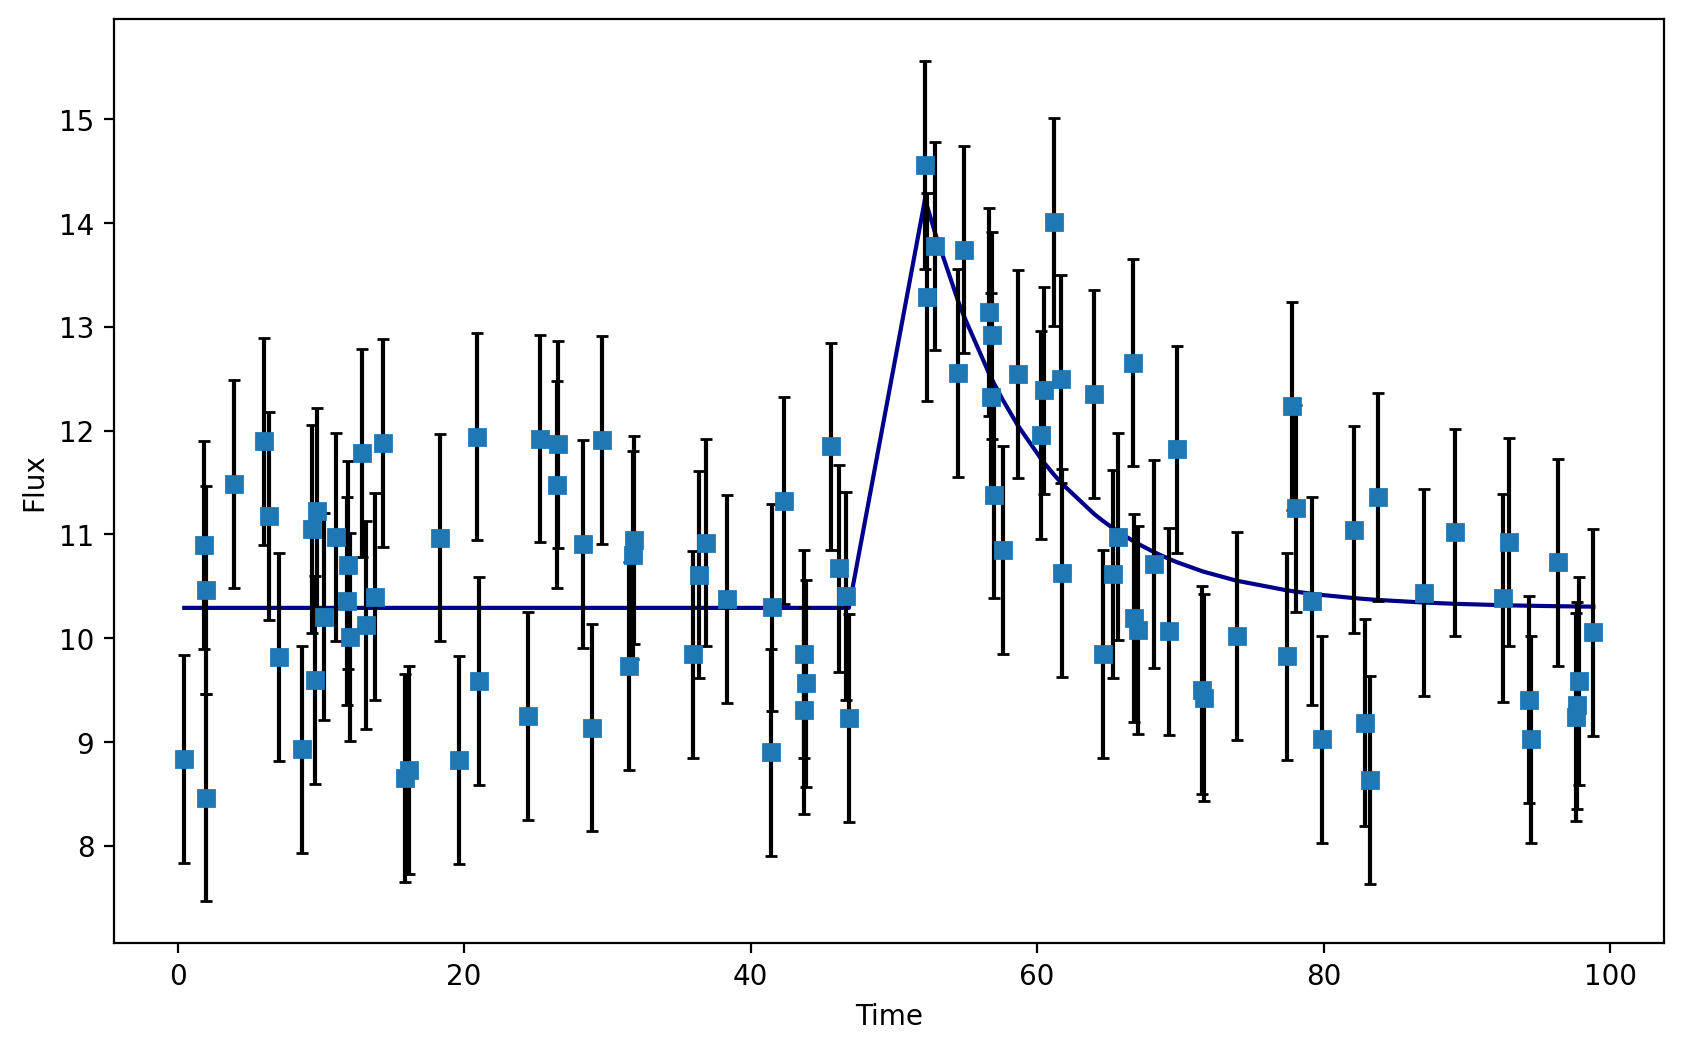

In [132]:

fig, ax = plt.subplots(figsize=(10,6))
burst_params[2] = np.log(burst_params[2])
y_fit = burst_fit(burst_params, t)  
ax.plot(t, y_fit, color='darkblue')  
ax.errorbar(t, flux, yerr=uncert,ls='', capsize=2, color='black')
ax.plot(t, flux, 's')


ax.set_ylabel('Flux')
ax.set_xlabel('Time')
plt.show()

In [140]:
gauss_ev = result_ult['logz']
burst_ev = result_burst['logz']

bayes_fact = np.exp(burst_ev) / np.exp(gauss_ev) 

print(bayes_fact)

65.06326348422839
